## Clustering the Countries by using Unsupervised Learning for "HELP International" oraganization


# `Description of the data set`

Here we use data from [kaggle](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv) 


1. child_mort: Death of children under 5 years of age per 1000 live births

2. exports: Exports of goods and services per capita. Given as %age of the GDP per capita 

3. health: Total health spending per capita. Given as %age of GDP per capita

4. imports: Imports of goods and services per capita. Given as %age of the GDP per capita 

5. Income: Net income per person 

6. Inflation: The measurement of the annual growth rate of the Total GDP

7. life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same

8. total_fer The number of children that would be born to each woman if the current age-fertility rates remain the same.

9. gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.

#### Objective:

To categorise the countries using socio-economic and health factors that determine the overall development of the country.

#### About organization:

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

#### Problem Statement:

HELPING International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, our Job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then to suggest the countries which the CEO needs to focus on the most.




# `Plan for data exploration`:

1. Exploring and feature engineering 
    * Examine the data types and value_counts
    * removing unimportant data if found 
    * dealing with missing (NaN) values if found
    * Transforming Skewed Continuous Features
    * see the data distribution
    * feature scalling for continuous variables if needed
    * encoding for categorical variables if found as to Encode the activity label as an integer
2. Clustering
    * K_Means
    * AgglomerativeClustering
    * DBSCAN
    * MeanShift
3. Selecting the best model
4. Conclusion and Next Steps


# `Exploring and feature engineering`

In [1]:
#importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth


In [2]:
df= pd.read_csv('Country-data.csv',sep=',')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df.shape

(167, 10)

In [4]:
df.dtypes.value_counts()

float64    7
int64      2
object     1
dtype: int64

The data columns are all numeric except for the 'country' label

In [5]:
df_new = df.drop(columns='country')

In [6]:
for column in df_new:
    df_new[column] =df_new[column].astype(float)

df_new.dtypes.value_counts()

float64    9
dtype: int64

In [7]:
# checking for missing values
df_new.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

we will drop the country column as it's not useful for us

In [8]:
# see the min and max of data excluding the target
print('min = ',df_new.iloc[:, :-1].min().value_counts())
print('max = ',df_new.iloc[:, :-1].max().value_counts())

min =   2.6000      1
 0.1090      1
 1.8100      1
 0.0659      1
 609.0000    1
-4.2100      1
 32.1000     1
 1.1500      1
dtype: int64
max =  208.00       1
200.00       1
17.90        1
174.00       1
125000.00    1
104.00       1
82.80        1
7.49         1
dtype: int64


## Transforming Skewed Features


In [9]:
skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = df_new[df_new.columns].skew()

In [10]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
inflation,5.154049
exports,2.445824
income,2.231480
gdpp,2.218051
imports,1.905276
child_mort,1.450774
total_fer,0.967092
life_expec,-0.970996


In [11]:
# Perform the skew transformation:
for col in skew_cols.index.values:
    df_new[col] = df_new[col].apply(np.log1p)

array([[<AxesSubplot:title={'center':'child_mort'}>,
        <AxesSubplot:title={'center':'exports'}>,
        <AxesSubplot:title={'center':'health'}>],
       [<AxesSubplot:title={'center':'imports'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'inflation'}>],
       [<AxesSubplot:title={'center':'life_expec'}>,
        <AxesSubplot:title={'center':'total_fer'}>,
        <AxesSubplot:title={'center':'gdpp'}>]], dtype=object)

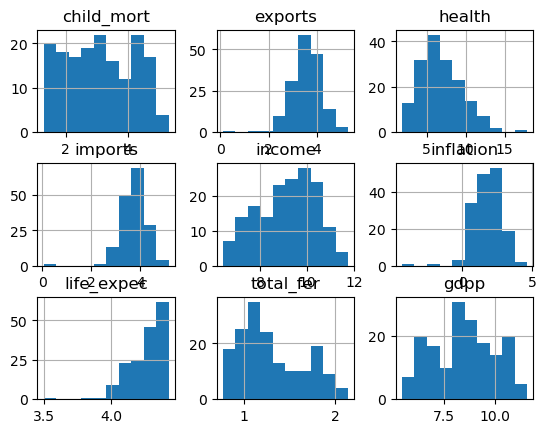

In [12]:
df_new.hist()

## looking at correlation

In [13]:
# The correlation matrix
corr_mat = df_new.corr()
# Strip out the diagonal values for the next step
for x in range(len(df_new.columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,0.000000,-0.406777,-0.339588,-0.140941,-0.859310,0.449998,-0.848914,0.864312,-0.874668
exports,-0.406777,0.000000,-0.074494,0.665583,0.510340,-0.156595,0.306579,-0.355055,0.465639
health,-0.339588,-0.074494,0.000000,0.126102,0.149877,-0.340010,0.178207,-0.232129,0.270389
imports,-0.140941,0.665583,0.126102,0.000000,0.020655,-0.256076,0.002593,-0.096608,0.043145
income,-0.859310,0.510340,0.149877,0.020655,0.000000,-0.268519,0.770702,-0.774803,0.972024
inflation,0.449998,-0.156595,-0.340010,-0.256076,-0.268519,0.000000,-0.299389,0.391213,-0.348723
life_expec,-0.848914,0.306579,0.178207,0.002593,0.770702,-0.299389,0.000000,-0.734395,0.756654
total_fer,0.864312,-0.355055,-0.232129,-0.096608,-0.774803,0.391213,-0.734395,0.000000,-0.738092
gdpp,-0.874668,0.465639,0.270389,0.043145,0.972024,-0.348723,0.756654,-0.738092,0.000000


In [14]:
corr_mat.abs().idxmax()

child_mort          gdpp
exports          imports
health         inflation
imports          exports
income              gdpp
inflation     child_mort
life_expec    child_mort
total_fer     child_mort
gdpp              income
dtype: object

Text(0.5, 0, 'Net income per person ')

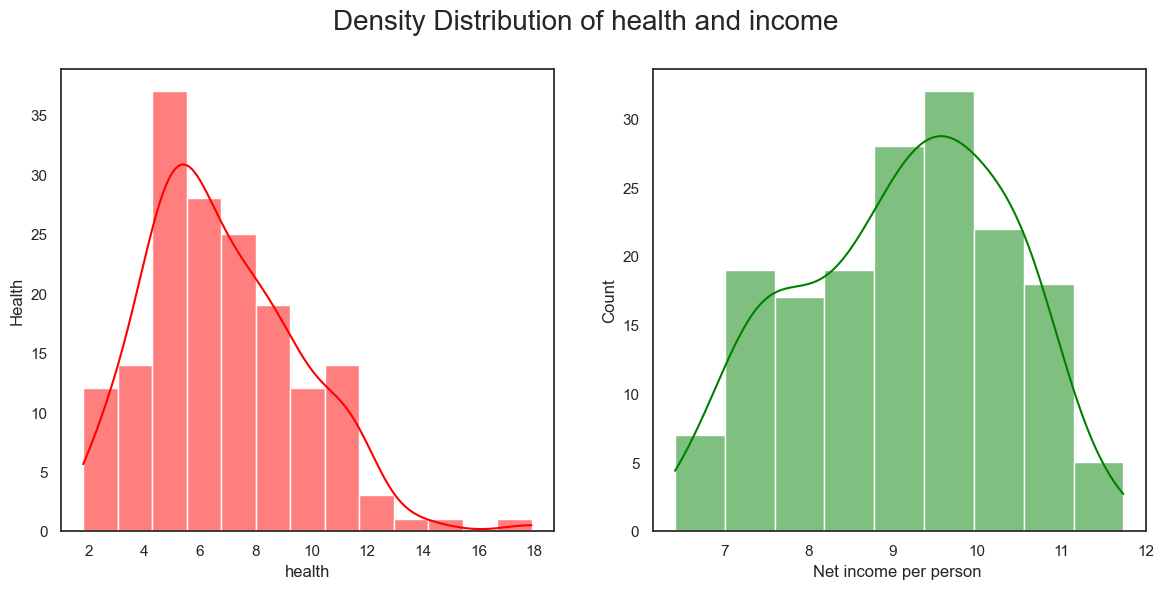

In [15]:
#  let's look at distribution of health and income
sns.set_context('notebook')
sns.set_style('white')

plt.figure(figsize=(14,6))
plt.suptitle('Density Distribution of health and income', size=20)

# create first histplot
plt.subplot(1,2,1)
sns.histplot(df_new['health'], kde=True, color='red')
plt.ylabel('Health')

# create second histplot
plt.subplot(1,2,2)
sns.histplot(df_new['income'], kde=True, color='green')
plt.xlabel('Net income per person ')

In [16]:
#scaling
mms = MinMaxScaler()

for col in df_new.columns:
    df_new[col] = mms.fit_transform(df_new[[col]]).squeeze()

In [17]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,0.454720,0.267697,0.0,0.232179,0.425884,0.705123,1.0
exports,167.0,0.663427,0.126306,0.0,0.597592,0.669262,0.741271,1.0
health,167.0,0.311106,0.170717,0.0,0.193288,0.280298,0.422001,1.0
imports,167.0,0.722024,0.105885,0.0,0.661949,0.730678,0.789330,1.0
income,167.0,0.507677,0.230849,0.0,0.320338,0.524737,0.680321,1.0
inflation,163.0,0.677629,0.116671,0.0,0.603311,0.689902,0.758904,1.0
life_expec,167.0,0.820643,0.146971,0.0,0.747827,0.867566,0.920022,1.0
total_fer,167.0,0.394844,0.257675,0.0,0.191029,0.335836,0.596801,1.0
gdpp,167.0,0.499336,0.245200,0.0,0.285665,0.490638,0.670965,1.0


In [18]:
df_new.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     4
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [19]:
df_new[df_new['inflation'].isnull()]

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
43,0.049409,0.788722,0.377253,0.802495,0.720922,NaN,0.929665,0.112722,0.727189
73,0.090541,0.873282,0.458670,0.864115,0.810957,NaN,0.968718,0.254601,0.874363
77,0.037955,0.513309,0.477315,0.513080,0.765088,NaN,1.000000,0.077052,0.859614
131,0.357865,0.855470,0.098819,0.907187,0.659427,NaN,0.871916,0.282698,0.628073


In [20]:
df_new.fillna(0,inplace=True)

# `Clustering`

cluster analysis of health and income

In [21]:
X = df_new[['health','income']]

## 1.K-Means

In [22]:
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)

Text(0.5, 1.0, 'The Elbow Method')

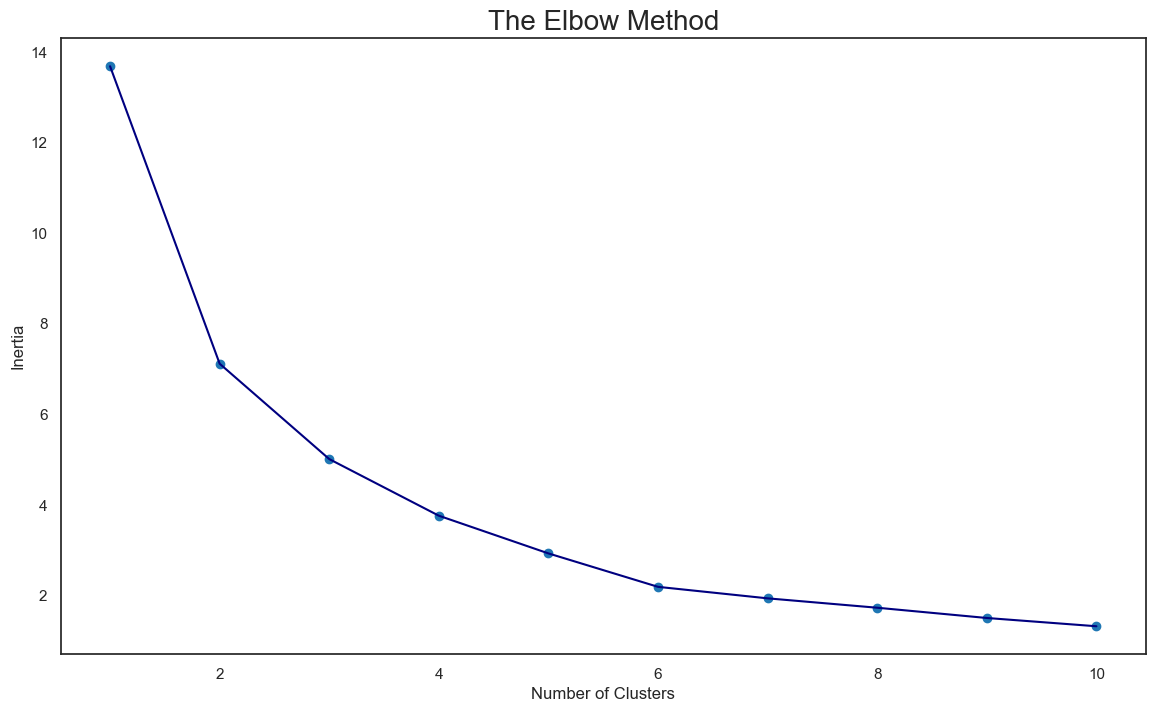

In [23]:
# elbow method

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(list_num_clusters,inertia, color='navy')
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method', fontsize=20)

# Annotate arrow
# ax.annotate('Possible Elbow Point', xy=(5, 4), xytext=(5, 6), xycoords='data',          
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2))

In [24]:
X = df_new[['health','income']]

In [25]:
# silhouette index
from sklearn.metrics import silhouette_score

range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters).fit(X)
    preds = clusterer.predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4282963858414001
For n_clusters = 3, silhouette score is 0.3829484769108311
For n_clusters = 4, silhouette score is 0.3753267077908493
For n_clusters = 5, silhouette score is 0.40149383455092047
For n_clusters = 6, silhouette score is 0.40793792926510875
For n_clusters = 7, silhouette score is 0.37283607265889346
For n_clusters = 8, silhouette score is 0.3860104655438416
For n_clusters = 9, silhouette score is 0.371306928276858


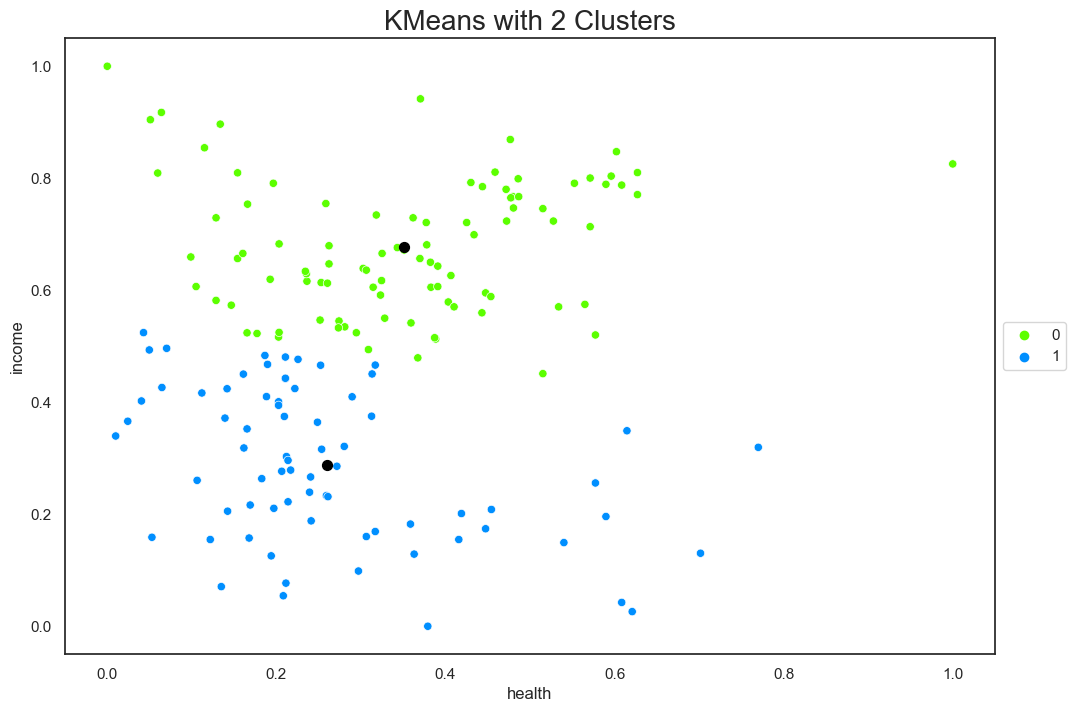

In [26]:
# 2 cluster
km6 = KMeans(n_clusters=2).fit(X)

X['Labels'] = km6.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('gist_rainbow', 2))
plt.scatter(km6.cluster_centers_[:, 0], km6.cluster_centers_[:, 1], s = 50, c = 'black')
plt.xlabel('health')
plt.ylabel('income')
plt.title('KMeans with 2 Clusters', fontsize=20)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)

In [27]:
df['Labels'] = km6.labels_
df[['country','Labels']].sample(5)

,country,Labels
122,Portugal,0
3,Angola,1
84,Lao,1
36,Comoros,1
35,Colombia,0


Based on those two graphs above I can concluded that KMeans with 2 clusters gave better insights about clustering income and health

## 2.Hierarchical Clustering


In [28]:
# silhouette index
from sklearn.metrics import silhouette_score

range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    ward = AgglomerativeClustering(n_clusters=n_clusters)
    ward = ward.fit(X)
    preds = ward.fit_predict(X)
    
    score = silhouette_score (X, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.7736815850029132
For n_clusters = 3, silhouette score is 0.5679359799172009
For n_clusters = 4, silhouette score is 0.45427874560263365
For n_clusters = 5, silhouette score is 0.4690255415652699
For n_clusters = 6, silhouette score is 0.43514539970139976
For n_clusters = 7, silhouette score is 0.4028804062034183
For n_clusters = 8, silhouette score is 0.40761724511998054
For n_clusters = 9, silhouette score is 0.3904331844243769


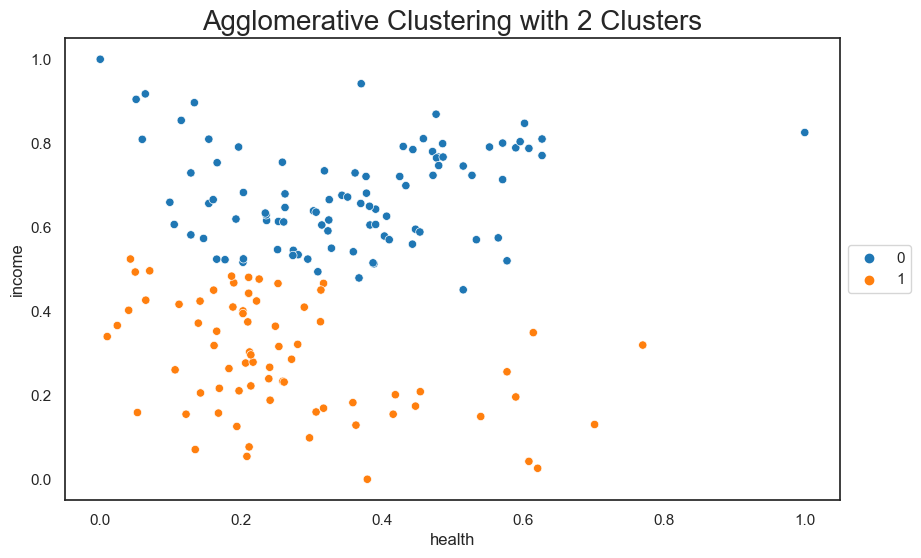

In [29]:
agglom = AgglomerativeClustering(n_clusters=2).fit(X)

X['Labels'] = agglom.labels_
plt.figure(figsize=(10, 6))
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('tab10', 2))
plt.xlabel('health')
plt.ylabel('income')
plt.title('Agglomerative Clustering with 2 Clusters', fontsize=20)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)

Both clustering algorithms: KMeans and Hierarchical Clustering did good job in labeling our countries into 2 different groups and both results are similar.

Text(0.5, 1.0, 'Dendrogram')

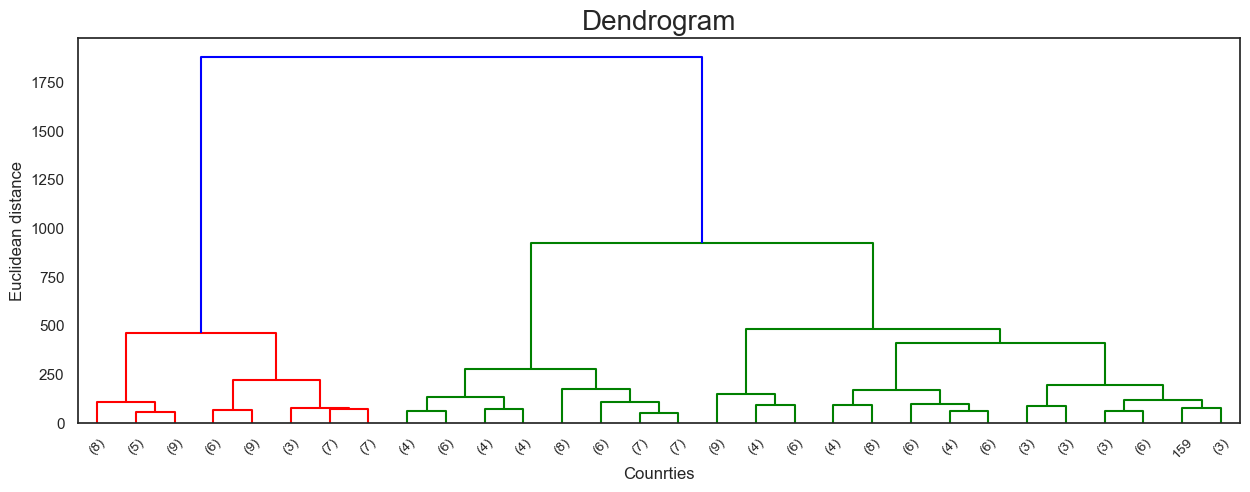

In [30]:
from scipy.cluster import hierarchy
HL = hierarchy.linkage(agglom.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

hierarchy.set_link_color_palette(['red', 'green'])

den = hierarchy.dendrogram(HL, orientation='top', 
                           p=30, truncate_mode='lastp',
                            show_leaf_counts=True, ax=ax,
                           above_threshold_color='blue')
plt.xlabel('Counrties')
plt.ylabel('Euclidean distance')
plt.title('Dendrogram', fontsize=20)

## 3.DBSCAN


In [31]:
# determine epsilon and min_samples values
epsilon = 10
min_samples = 5

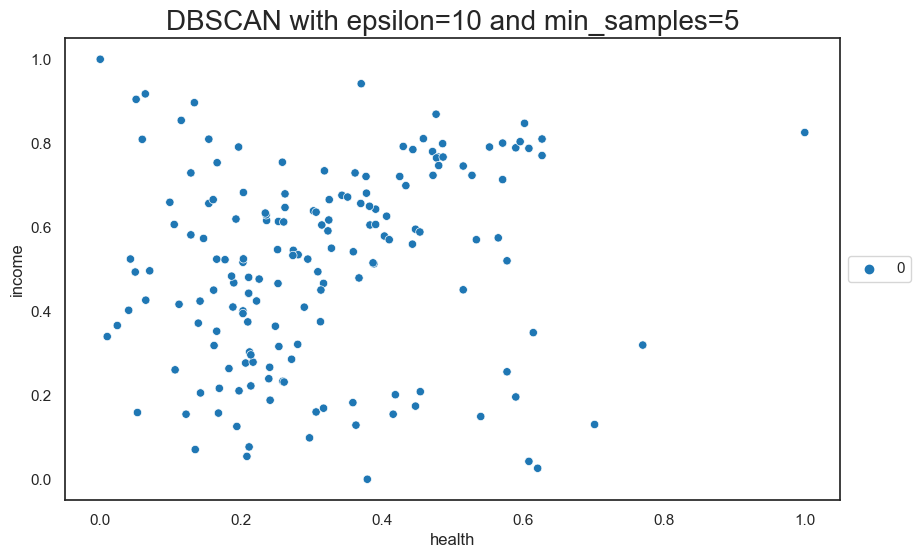

In [32]:
# DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)

X['Labels'] = db.labels_
plt.figure(figsize=(10, 6))
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette='tab10')
plt.xlabel('health')
plt.ylabel('income')
plt.title('DBSCAN with epsilon=10 and min_samples=5', fontsize=20)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)

No matter what value of epsilon or min_samples I took, the algorithm performed in similar way - all data was classified as one group. The reason why DBSCAN doesn't perform very well is a fact that density in our data isn't so strong. Probably, if the dataset will be bigger DBSCAN will donne better job.

## 4.Mean Shift

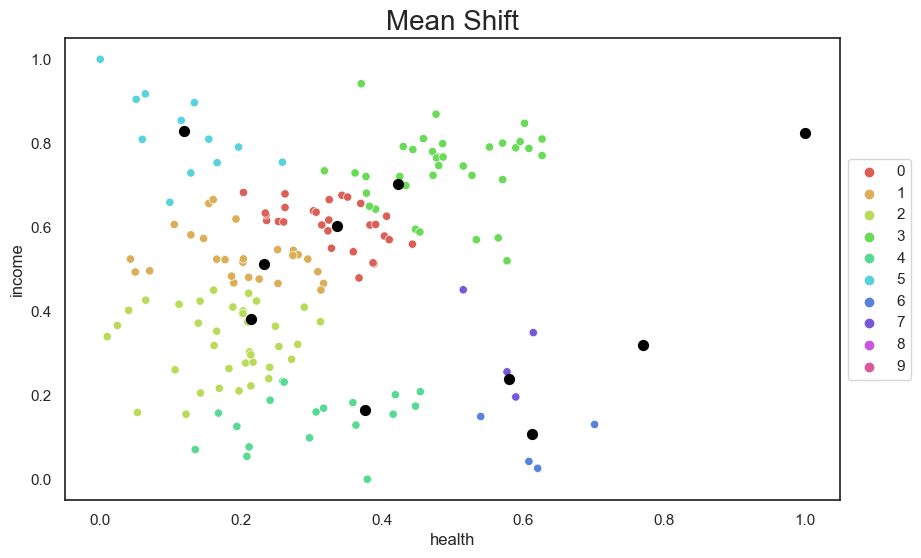

In [33]:
# the following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.1)

# MeanShift 
ms = MeanShift(bandwidth=bandwidth).fit(X)

X['Labels'] = ms.labels_
plt.figure(figsize=(10, 6))
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
plt.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1], s = 50, c = 'black')
plt.xlabel('health')
plt.ylabel('income')
plt.title('Mean Shift', fontsize=20)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)

# `All in one place and selecting the best model`


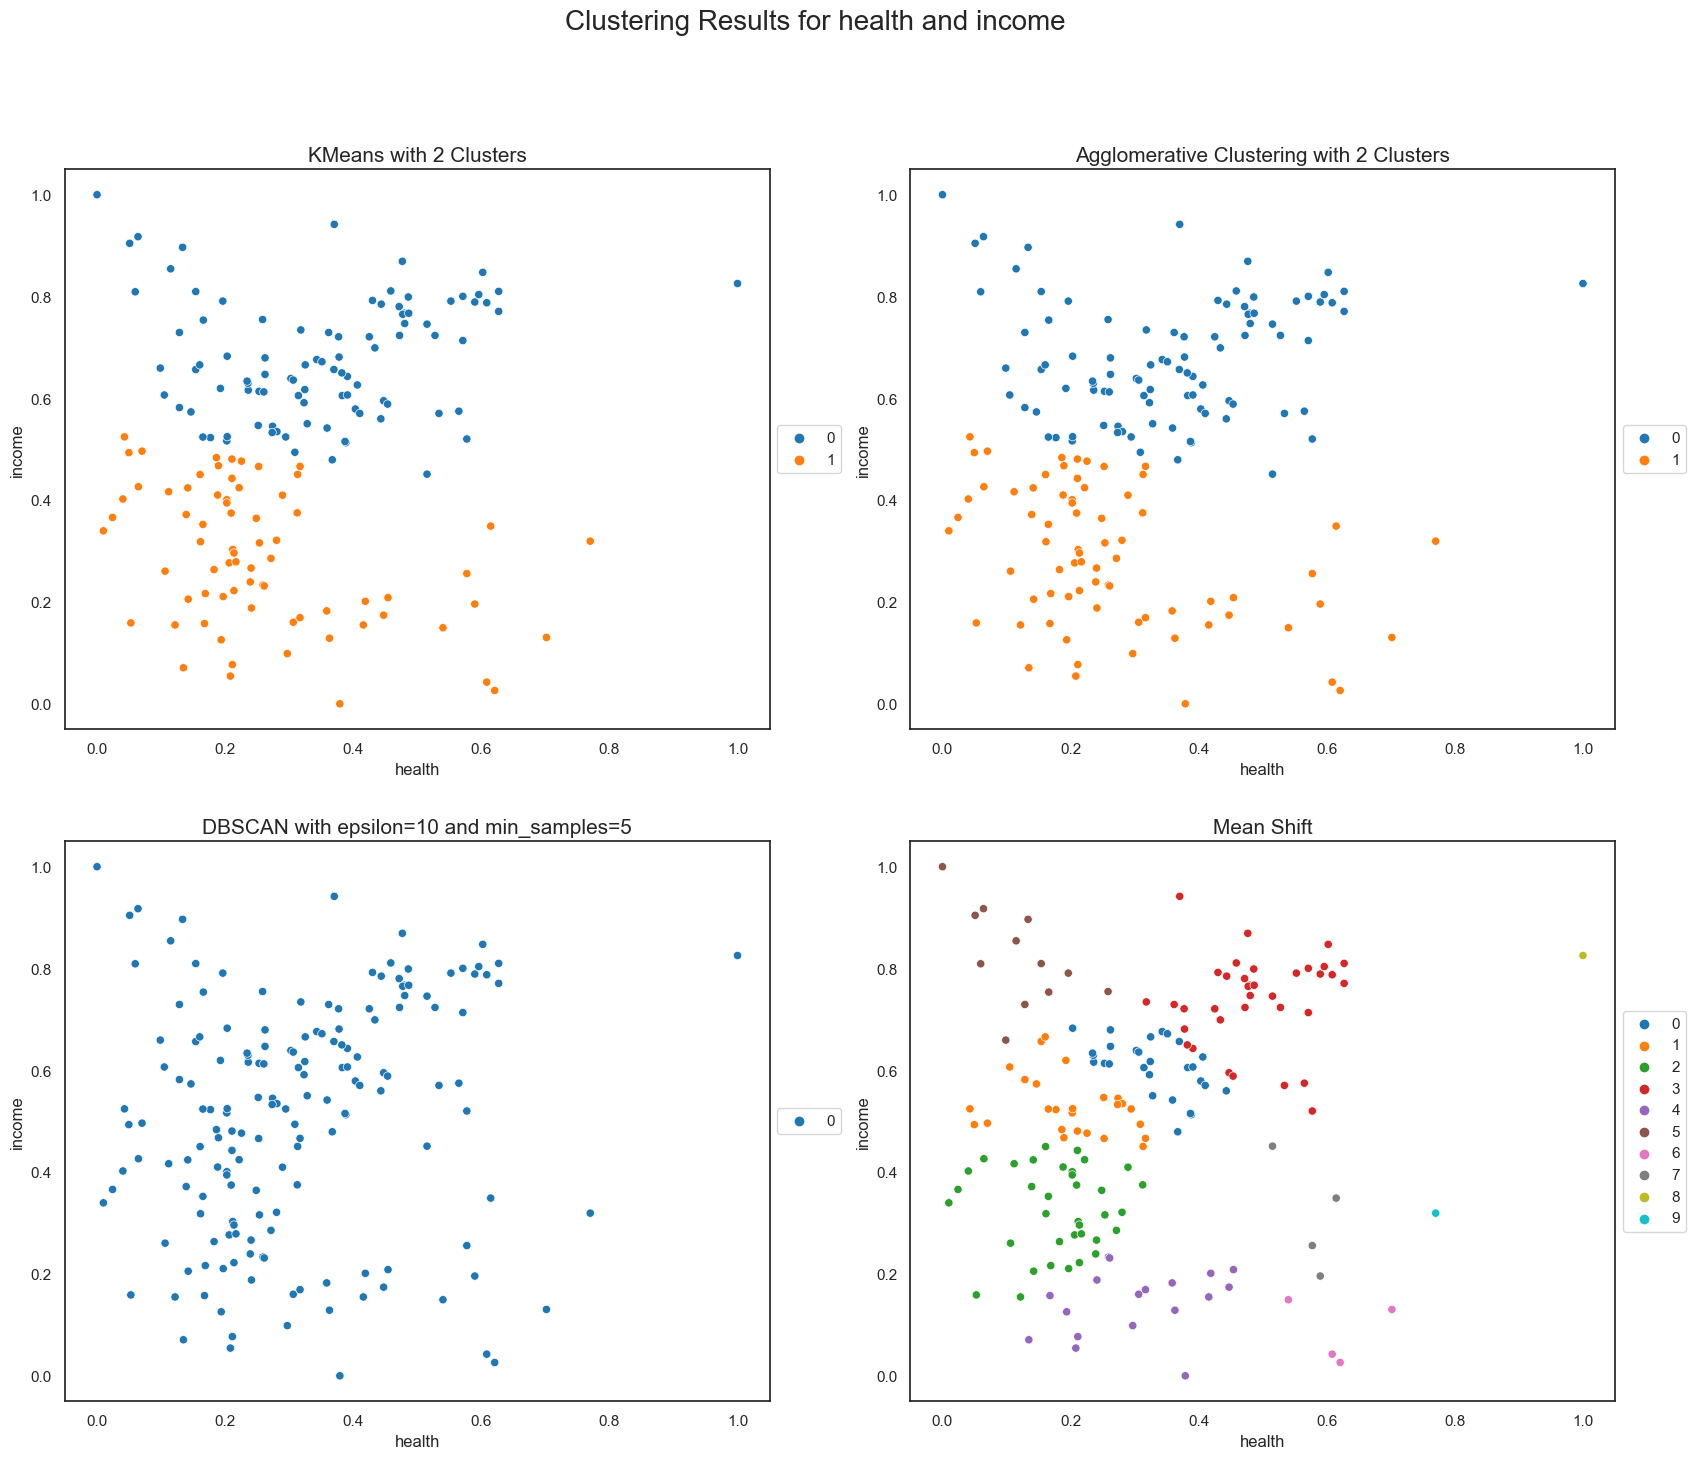

In [34]:
X = df_new[['health','income']]

plt.figure(figsize=(20,16))
plt.suptitle('Clustering Results for health and income', fontsize=20)

plt.subplot(221)
km5 = KMeans(n_clusters=2).fit(X)
X['Labels'] = km5.labels_
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('tab10', 2))
plt.xlabel('health')
plt.ylabel('income')
plt.title('KMeans with 2 Clusters', fontsize=15)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)


plt.subplot(222)
agglom = AgglomerativeClustering(n_clusters=2).fit(X)
X['Labels'] = agglom.labels_
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('tab10', 2))
plt.xlabel('health')
plt.ylabel('income')
plt.title('Agglomerative Clustering with 2 Clusters', fontsize=15)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)


plt.subplot(223)
db = DBSCAN(eps=10, min_samples=5).fit(X)
X['Labels'] = db.labels_
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette='tab10')
plt.xlabel('health')
plt.ylabel('income')
plt.title('DBSCAN with epsilon=10 and min_samples=5', fontsize=15)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)


plt.subplot(224)
bandwidth = estimate_bandwidth(X, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth).fit(X)
X['Labels'] = ms.labels_
sns.scatterplot(X['health'], X['income'], hue=X['Labels'], 
                palette=sns.color_palette('tab10', np.unique(ms.labels_).shape[0]))
plt.xlabel('health')
plt.ylabel('income')
plt.title('Mean Shift', fontsize=15)
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)


we will select AgglomerativeClustering

In [35]:
gglom = AgglomerativeClustering(n_clusters=2).fit(X)
df['Clusterts'] = agglom.labels_

In [36]:
Results = df[['Clusterts','country']].groupby(['Clusterts','country']).mean()
Results

Empty DataFrame
Columns: []
Index: [(0, Albania), (0, Algeria), (0, Antigua and Barbuda), (0, Argentina), (0, Australia), (0, Austria), (0, Azerbaijan), (0, Bahamas), (0, Bahrain), (0, Barbados), (0, Belarus), (0, Belgium), (0, Bosnia and Herzegovina), (0, Botswana), (0, Brazil), (0, Brunei), (0, Bulgaria), (0, Canada), (0, Chile), (0, China), (0, Colombia), (0, Costa Rica), (0, Croatia), (0, Cyprus), (0, Czech Republic), (0, Denmark), (0, Dominican Republic), (0, Ecuador), (0, Egypt), (0, Equatorial Guinea), (0, Estonia), (0, Finland), (0, France), (0, Gabon), (0, Georgia), (0, Germany), (0, Greece), (0, Grenada), (0, Hungary), (0, Iceland), (0, Iran), (0, Iraq), (0, Ireland), (0, Israel), (0, Italy), (0, Japan), (0, Jordan), (0, Kazakhstan), (0, Kuwait), (0, Latvia), (0, Lebanon), (0, Libya), (0, Lithuania), (0, Luxembourg), (0, Macedonia, FYR), (0, Malaysia), (0, Maldives), (0, Malta), (0, Mauritius), (0, Montenegro), (0, Namibia), (0, Netherlands), (0, New Zealand), (0, Norway), (0, Oman), (0, Panama), (0, Peru), (0, Poland), (0, Portugal), (0, Qatar), (0, Romania), (0, Russia), (0, Saudi Arabia), (0, Serbia), (0, Seychelles), (0, Singapore), (0, Slovak Republic), (0, Slovenia), (0, South Africa), (0, South Korea), (0, Spain), (0, St. Vincent and the Grenadines), (0, Suriname), (0, Sweden), (0, Switzerland), (0, Thailand), (0, Tunisia), (0, Turkey), (0, Ukraine), (0, United Arab Emirates), (0, United Kingdom), (0, United States), (0, Uruguay), (0, Venezuela), (1, Afghanistan), (1, Angola), (1, Armenia), (1, Bangladesh), (1, Belize), (1, Benin), ...]

[167 rows x 0 columns]

## * Label 1: low income and low/mid health --> target
## * Label 0: high income and mid health --> avoid

# `Conclusion`


K-means and Agglomerative Clustering with 2 Clusters performed best according to the silhouette_score

####  possible flaws:
this dataset from Kaggle was really small one. Because of it DBSCAN couldn't perform well.
